In [1]:
import pandas_datareader.data as web
import os
from dotenv import load_dotenv
import pandas as pd

In [2]:
BASEDIR = os.path.join(os.getcwd(), '..')
load_dotenv(os.path.join(BASEDIR, '.env'))

True

In [27]:
start_date = '2016-04-04'
end_date = '2019-04-04'
name = 'AMZN'

In [28]:
df = web.DataReader(name=name, data_source='quandl', start=start_date, end=end_date, access_key=os.getenv("quandle_key"))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: the 'access_key' keyword is deprecated, use 'api_key' instead
  """Entry point for launching an IPython kernel.


In [29]:
# Importing the data
df

,Open,High,Low,Close,Volume,ExDividend,SplitRatio,AdjOpen,AdjHigh,AdjLow,AdjClose,AdjVolume
Date,,,,,,,,,,,,
2018-03-27,1572.40,1575.96,1482.32,1497.05,6793279.0,0.0,1.0,1572.40,1575.96,1482.32,1497.05,6793279.0
2018-03-26,1530.00,1556.99,1499.25,1555.86,5547618.0,0.0,1.0,1530.00,1556.99,1499.25,1555.86,5547618.0
2018-03-23,1539.01,1549.02,1495.36,1495.56,7843966.0,0.0,1.0,1539.01,1549.02,1495.36,1495.56,7843966.0
2018-03-22,1565.47,1573.85,1542.40,1544.10,6177737.0,0.0,1.0,1565.47,1573.85,1542.40,1544.10,6177737.0
2018-03-21,1586.45,1590.00,1563.17,1581.86,4667291.0,0.0,1.0,1586.45,1590.00,1563.17,1581.86,4667291.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2016-04-08,594.32,597.86,589.00,594.60,2591936.0,0.0,1.0,594.32,597.86,589.00,594.60,2591936.0
2016-04-07,598.76,599.60,589.08,591.43,3189037.0,0.0,1.0,598.76,599.60,589.08,591.43,3189037.0
2016-04-06,587.52,602.39,587.50,602.08,2849909.0,0.0,1.0,587.52,602.39,587.50,602.08,2849909.0


In [30]:
# Graphing the data
import matplotlib.pyplot as plt
%matplotlib inline

In [31]:
df['mid_data'] = (df['High']+df['Low'])/2

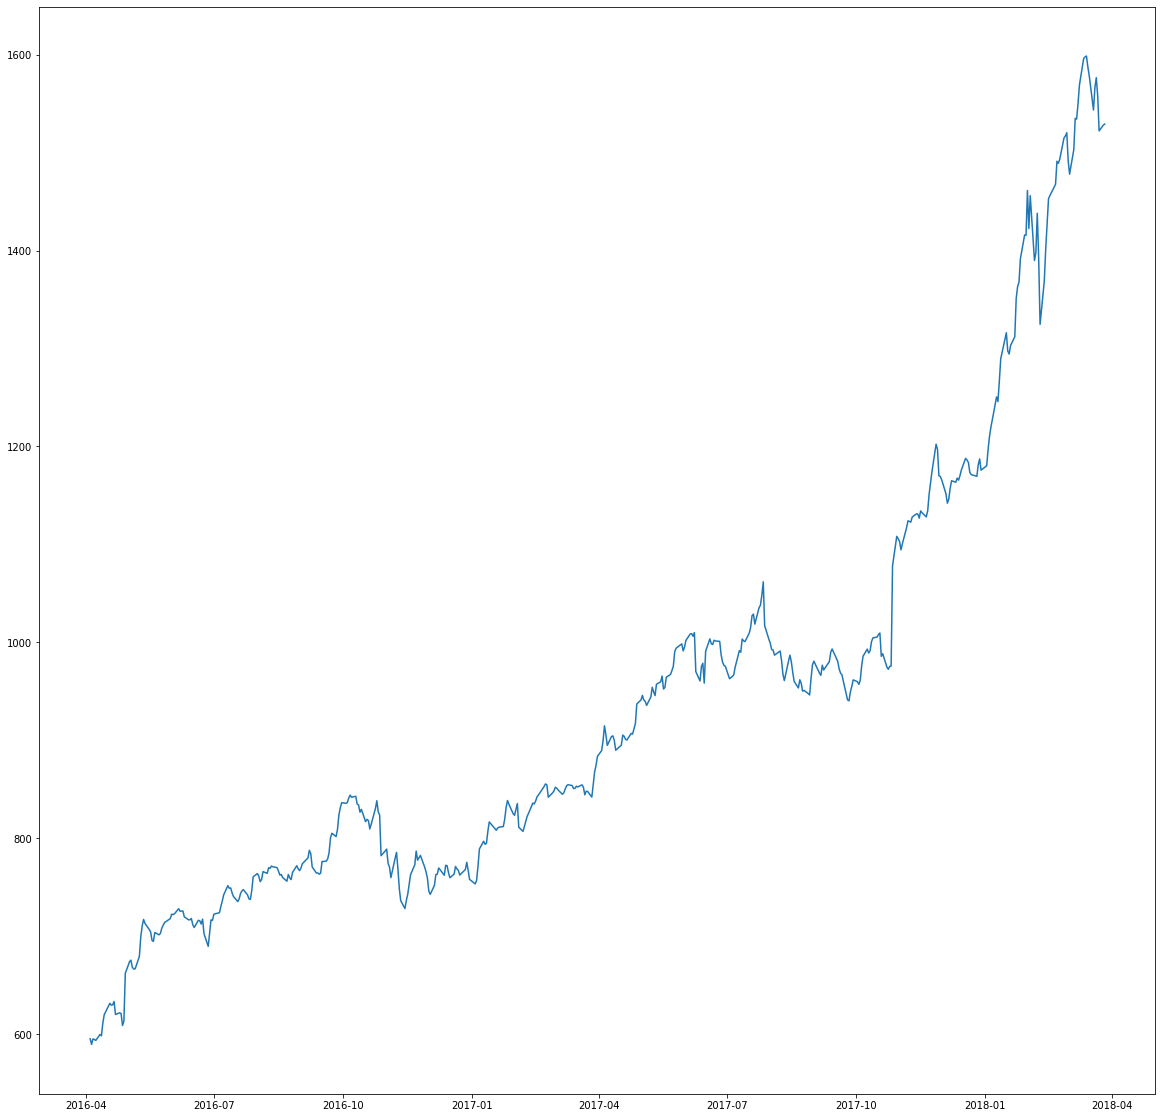

In [32]:
plt.figure(figsize=(20, 20))
plt.plot(df.index, df['mid_data'])

In [85]:
df_train = pd.DataFrame()
# df_train['Date'] = df.index
df_train['Data'] = df['mid_data'].values[::-1]


In [86]:
y = df_train['Data'].values

In [87]:
# Data preprocessing
from sklearn.preprocessing import MinMaxScaler 
from keras.preprocessing.sequence import TimeseriesGenerator
import numpy as np

class preprocess_data:
    def __init__(self, y, timesteps, num_predict):
        self.data = y
        self.timesteps = timesteps
        self.num_predict= num_predict
        self.scaler = MinMaxScaler(feature_range=(-1, 1))
        self.data = self.scaler.fit_transform(y.reshape(-1, 1))
        self.x, self.y = self.reformat_data()
        
    def reformat_data(self):
        batch = TimeseriesGenerator(self.data, self.data, length=self.timesteps, batch_size=len(self.data)).__iter__().__next__()
        return batch[0][:1 - self.num_predict], self.extend_y(batch[1]).reshape((-1, self.num_predict))
        
    def extend_y(self, y_batch):
        test = np.array(
            [y_batch[i:i + self.num_predict] for i in range(len(y_batch[:1 - self.num_predict]))])
        if len(y_batch[:1 - self.num_predict]) == 0:
            return 0
        return test

In [88]:
data = preprocess_data(y, timesteps=100, num_predict=5)

In [89]:
# Imports
from keras.models import Sequential
from keras.layers import Dropout, Dense, LSTM
from keras.optimizers import Adam

In [90]:
class lstm:
    def __init__(self, data, timesteps, num_predict, dropout=0.2, val_split=0.2, num_neurons=5, epochs=5):
        self.data = data
        self.timesteps = timesteps
        self.num_predict = num_predict
        self.dropout = dropout
        self.val_split = val_split
        self.num_neurons = num_neurons
        self.epochs = epochs
        
        # Defining the model
        self.model = Sequential()
        self.model.add(LSTM(self.num_neurons, input_shape=(self.timesteps, 1,), return_sequences=False))
        self.model.add(Dropout(rate=self.dropout))
        self.model.add(Dense(self.num_predict))
        
        adam = Adam(clipnorm=1)
        self.model.compile(optimizer=adam, loss='mean_squared_error')
        
    def train(self):
        try:
            self.history = self.model.fit(self.data.x, self.data.y, epochs = self.epochs, validation_split=self.val_split, shuffle=True)
            return True
        except:
            return False
        
    def predict(self, predict_data):
        try:
            self.model_out = self.model.predict(predict_data)
            return self.model_out
        except:
            return None
        
    def save_model(self):
        pass
    
    def load_model(self):
        pass
        
        
        

In [91]:
lstm_model = lstm(data, timesteps=100, num_neurons=10, num_predict=5, epochs=100)

In [92]:
lstm_model.train()

Train on 315 samples, validate on 79 samples
Epoch 1/100
315/315 [==============================] - 1s 2ms/step - loss: 0.2272 - val_loss: 0.4351
Epoch 2/100
315/315 [==============================] - 0s 629us/step - loss: 0.1832 - val_loss: 0.4295
Epoch 3/100
315/315 [==============================] - 0s 698us/step - loss: 0.1459 - val_loss: 0.4251
Epoch 4/100
315/315 [==============================] - 0s 667us/step - loss: 0.1170 - val_loss: 0.4216
Epoch 5/100
315/315 [==============================] - 0s 671us/step - loss: 0.0899 - val_loss: 0.4183
Epoch 6/100
315/315 [==============================] - 0s 686us/step - loss: 0.0693 - val_loss: 0.4149
Epoch 7/100
315/315 [==============================] - 0s 692us/step - loss: 0.0519 - val_loss: 0.4105
Epoch 8/100
315/315 [==============================] - 0s 703us/step - loss: 0.0398 - val_loss: 0.4050
Epoch 9/100
315/315 [==============================] - 0s 697us/step - loss: 0.0334 - val_loss: 0.3983
Epoch 10/100
315/315 [========

315/315 [==============================] - 0s 716us/step - loss: 0.0081 - val_loss: 0.1776
Epoch 80/100
315/315 [==============================] - 0s 643us/step - loss: 0.0069 - val_loss: 0.1755
Epoch 81/100
315/315 [==============================] - 0s 755us/step - loss: 0.0074 - val_loss: 0.1741
Epoch 82/100
315/315 [==============================] - 0s 737us/step - loss: 0.0078 - val_loss: 0.1722
Epoch 83/100
315/315 [==============================] - 0s 697us/step - loss: 0.0078 - val_loss: 0.1694
Epoch 84/100
315/315 [==============================] - 0s 752us/step - loss: 0.0068 - val_loss: 0.1675
Epoch 85/100
315/315 [==============================] - 0s 717us/step - loss: 0.0077 - val_loss: 0.1654
Epoch 86/100
315/315 [==============================] - 0s 668us/step - loss: 0.0070 - val_loss: 0.1632
Epoch 87/100
315/315 [==============================] - 0s 688us/step - loss: 0.0075 - val_loss: 0.1617
Epoch 88/100
315/315 [==============================] - 0s 802us/step - loss:

True

In [93]:
data.x.shape

(394, 100, 1)

In [94]:
pred_vals = lstm_model.predict(data.x[::-1])

In [95]:
pred_vals

array([[ 0.29565358,  0.35056227,  0.45100445,  0.24466477,  0.37785894],
       [ 0.29403895,  0.35152704,  0.45067018,  0.24158858,  0.378623  ],
       [ 0.29588777,  0.35150826,  0.45458317,  0.24267168,  0.37816548],
       ...,
       [-0.6375396 , -0.6356851 , -0.62870073, -0.62148386, -0.6337768 ],
       [-0.6345475 , -0.6323452 , -0.62550604, -0.6187533 , -0.63010836],
       [-0.6316532 , -0.62907386, -0.6225271 , -0.6161126 , -0.62650144]],
      dtype=float32)

In [96]:
pred_y

""


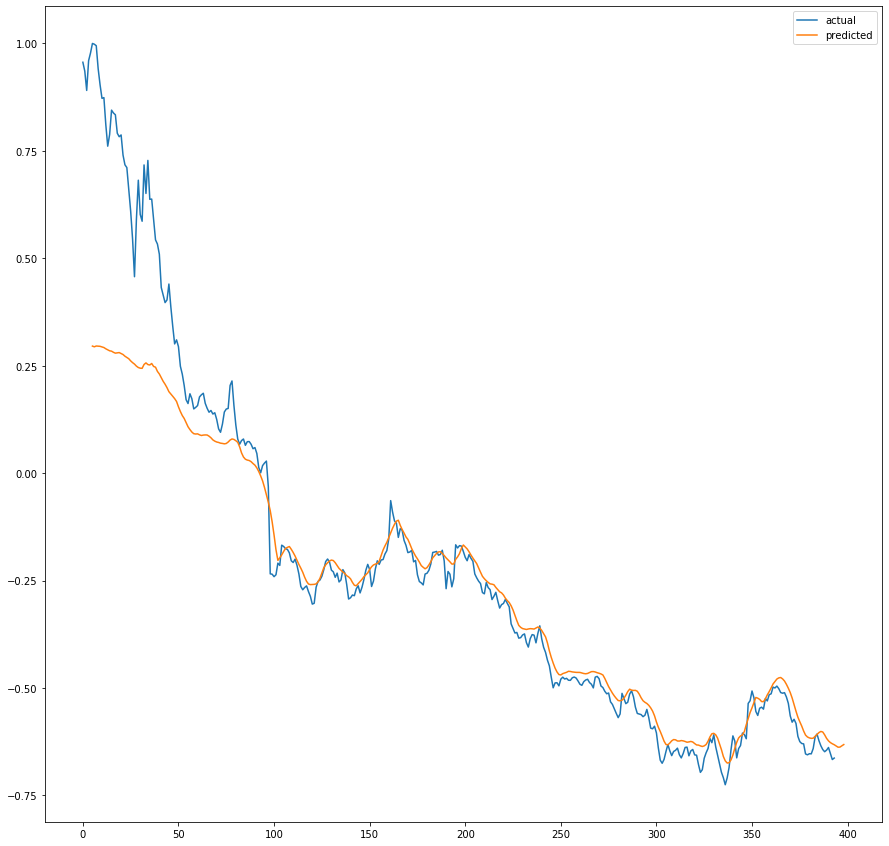

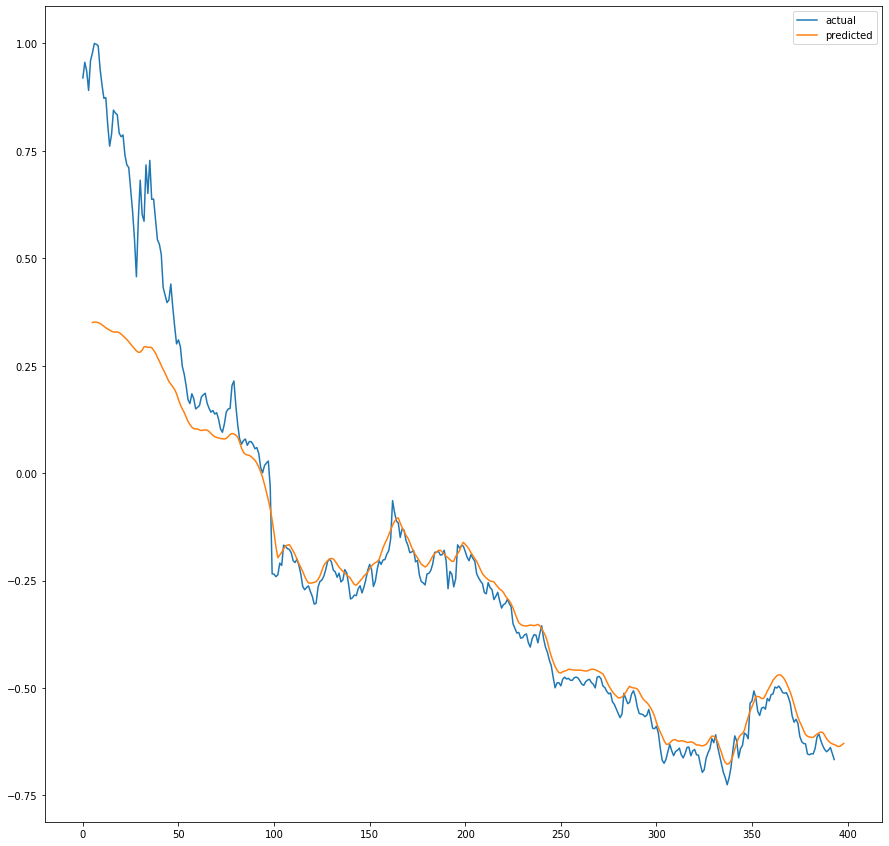

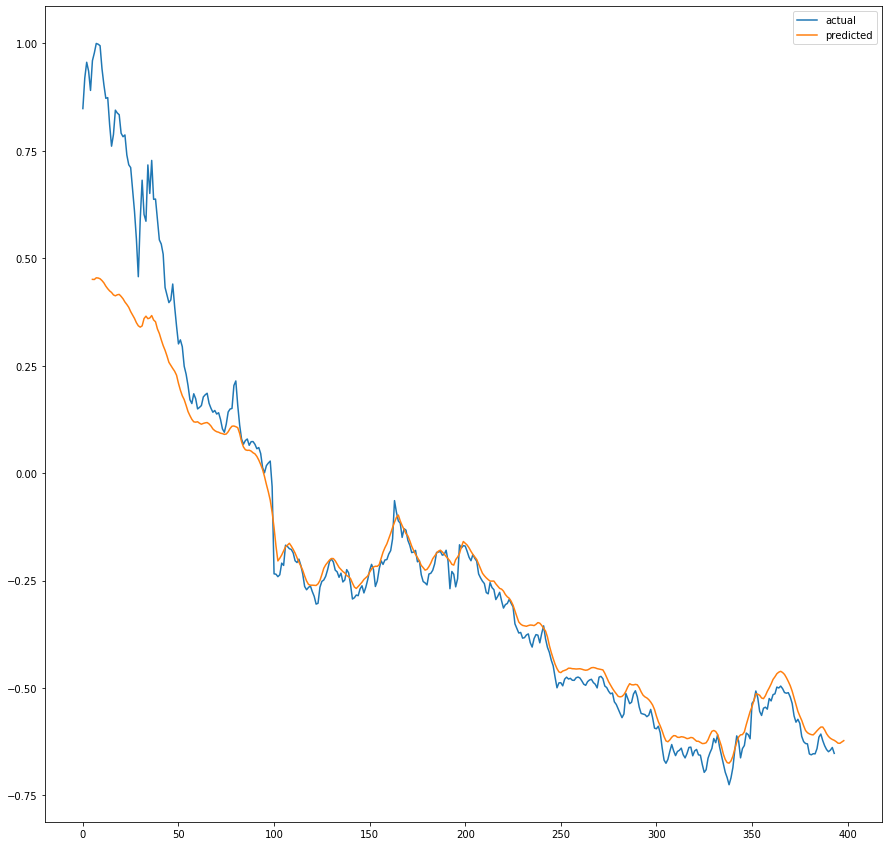

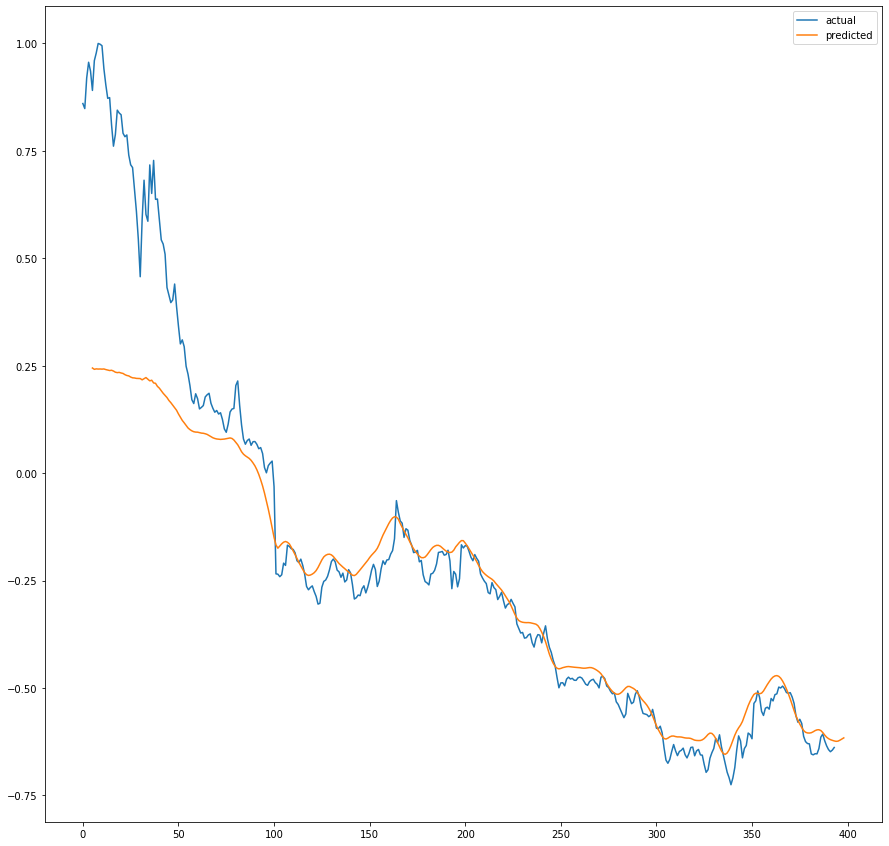

In [97]:
# Visualization
val_y = pd.DataFrame(data.y[::-1])
pred_y = pd.DataFrame(pred_vals)

for i in range(4):
    plt.figure(figsize=(15,15))
    plt.plot(val_y.iloc[:, i], label='actual')
    plt.plot((val_y.index.values+5), pred_y.iloc[:, i].values, label='predicted')
    plt.legend()

    plt.show()